In [2]:
#pip install --upgrade keras tensorflow

# !pip install tensorflow==2.13.0


In [3]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import tensorflow.keras as keras

import re

import nltk

from nltk.corpus import stopwords

import string

import json

from time import time

import pickle

from keras.applications.vgg16 import VGG16

from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from keras.preprocessing import image

from keras.models import Model, load_model

from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical

from keras.layers import Input, Dense, Dropout, Embedding, LSTM

from tensorflow.keras.layers import add


In [4]:


def readTextFile(path):

    with open(path) as f:

        caption = f.read()

    return caption

In [5]:
captions = readTextFile('/kaggle/input/mir-flickerdataset/Flickr8k_text/Flickr8k.token.txt')

In [6]:
captions = captions.split('\n')[:-1]

In [7]:
captions[161]

'1042020065_fb3d3ba5ba.jpg#1\tA boy in a green shirt watches kayakers .'

In [8]:
desc = {}



for x in captions:

    zyzz = x.split('#')

    img_name,img_captions= zyzz[0],zyzz[1]

    if desc.get(img_name) is None:

        desc[img_name] = []

    desc[img_name].append(img_captions)

In [9]:
desc['1000268201_693b08cb0e.jpg']

['0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1\tA girl going into a wooden building .',
 '2\tA little girl climbing into a wooden playhouse .',
 '3\tA little girl climbing the stairs to her playhouse .',
 '4\tA little girl in a pink dress going into a wooden cabin .']

In [10]:
import cv2

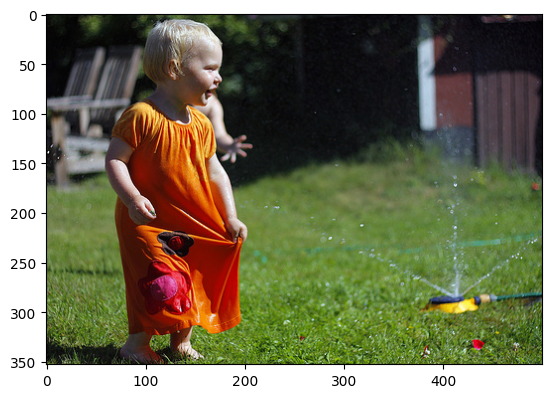

['0\tA baby girl in an orange dress gets wet as she stands next to a water sprinkler .',
 '1\tA blonde toddler wearing an orange dress is wet and standing beside a sprinkler in a yard .',
 '2\tA child in a dress is looking at a sprinkler',
 '3\tA little girl in an orange dress is running through the sprinkler in the yard .',
 '4\tOn wet grass , little blond girl in orange dress plays in sprinkler .']

In [11]:
import cv2

import matplotlib.pyplot as plt



path = '/kaggle/input/mir-flickerdataset/flicker8k dataset/Images/3767841911_6678052eb6.jpg'

image1 = cv2.imread(path)



if image1 is not None:

    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display

    plt.show()

else:

    print("Error: Image not found or cannot be read.")

desc['3767841911_6678052eb6.jpg']

DATA Cleaning

In [12]:
import re

In [13]:
def clean_text(sentence):

    sentence = sentence.lower()

    sentence = re.sub('[^a-z]+',' ', sentence)

    sentence = sentence.split()

    sentence = [s for s in sentence if len(s) > 1]

    sentence = ' '.join(sentence)

    return sentence


In [14]:
for key, caption_list in desc.items():

    for i in range(len(caption_list)):

        caption_list[i] = clean_text(caption_list[i])


In [15]:
# write the data to text file

with open('/kaggle/working/description.txt','w') as f:

    f.write(str(desc))

In [16]:
import json

descriptions = None

with open('/kaggle/working/description.txt') as f:

    descriptions = f.read()

json_acceptable_string = descriptions.replace("'","\"")

descriptions = json.loads(json_acceptable_string)


In [17]:
print(type(descriptions))

<class 'dict'>


In [18]:
descriptions.get('3237760601_5334f3f3b5.jpg')

['person wearing skis makes jump over the snow',
 'skier',
 'skier is in the air',
 'skier takes to great heights on snow covered mountain slope',
 'the man is skiing down snowy hill']

In [19]:
# Vocab



vocab = set()

for key in descriptions.keys():

    [vocab.update(sentence.split()) for sentence in descriptions[key]]



print("Vocab Size(unique words In Vocab) : %d"% len(vocab))

Vocab Size(unique words In Vocab) : 8423


In [20]:
vocab = set()

vocab.update(["hello", "apple"])

vocab.update(["hello"])

vocab.update(["hi"])

print(vocab)


{'hi', 'apple', 'hello'}


In [21]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [22]:
# Total No of words across all the sentences

total_words = []



for key in descriptions.keys():

    [total_words.append(i) for des in descriptions[key] for i in des.split()]



print("Total Words %d"%len(total_words))

Total Words 373793


In [23]:
len(total_words), type(total_words)

(373793, list)

In [24]:
import collections

counter = collections.Counter(total_words)

frq_cnt = dict(counter)

print(len(frq_cnt.keys()))

# print(frq_cnt)


8423


In [25]:
# sort the dictionary according to the freq count



sorted_freq_cnt = sorted(frq_cnt.items(), reverse = True, key=lambda x:x[1])



# filter

threshold =  10

sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]

total_words = [x[0] for x in sorted_freq_cnt]


In [26]:
print(len(total_words)) # 1800 unique words filter, this is going to be new vocab size

1845


TESt/Train

In [27]:
len(descriptions.keys()), len(descriptions.values())

(8092, 8092)

In [28]:
train_file_data = readTextFile('/kaggle/input/mir-flickerdataset/Flickr8k_text/Flickr_8k.trainImages.txt')

test_file_data = readTextFile('/kaggle/input/mir-flickerdataset/Flickr8k_text/Flickr_8k.testImages.txt')

In [29]:
train = [row.split('.')[0] for row in train_file_data.split('\n')[:-1]]

test = [row.split('.')[0] for row in test_file_data.split('\n')[:-1]]

In [30]:
len(train), len(test)

(6000, 1000)

In [31]:
print(descriptions.get('1000268201_693b08cb0e.jpg'))

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [32]:
test[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

In [33]:
# Prepare Description for the Training Data

# Tweak - Add <s> and <e> token to our training data

train_descriptions = {}

for img_id in train:

    train_descriptions[img_id] = []

    for cap in descriptions[img_id+'.jpg']:

        cap_to_append = "startseq " + cap + " endseq"

        train_descriptions[img_id].append(cap_to_append)

In [34]:
test_descriptions = {}
for img_id in test:
    test_descriptions[img_id] = []
    for cap in descriptions[img_id + '.jpg']:
        test_descriptions[img_id].append(cap)


In [35]:
test_descriptions["3072172967_630e9c69d0"]

['player from the white and green highschool team dribbles down court defended by player from the other team',
 'four basketball players in action',
 'four men playing basketball two from each team',
 'two boys in green and white uniforms play basketball with two boys in blue and white uniforms',
 'young men playing basketball in competition']

In [36]:
len(train_descriptions)

6000

In [37]:
train_descriptions["1000268201_693b08cb0e"]


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [38]:
model = ResNet50(weights = 'imagenet', input_shape = (224,224,3))

model.summary()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [39]:
model_new = Model(model.input,model.layers[-2].output)

In [40]:
from keras.preprocessing import image



def preprocess_img(img):

    img = image.load_img(img,target_size=(224,224))

    img = image.img_to_array(img)

    img = np.expand_dims(img,axis=0)

    # Normalisation

    img = preprocess_input(img)

    return img

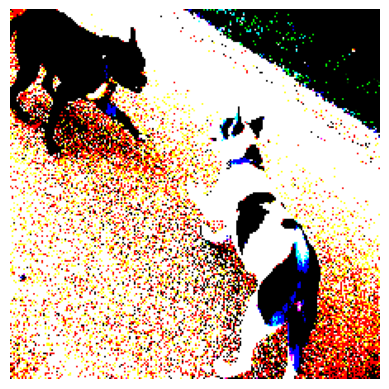

In [41]:
img1 = preprocess_img('/kaggle/input/mir-flickerdataset/flicker8k dataset/Images/1001773457_577c3a7d70.jpg')

plt.imshow(img1[0])

plt.axis("off")

plt.show()

In [42]:
def encode_image(img):

    img = preprocess_img(img)

    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((2048,))

    #print(feature_vector.shape)

    return feature_vector


In [43]:
encode_image('/kaggle/input/mir-flickerdataset/flicker8k dataset/Images/'+"1000268201_693b08cb0e.jpg")

I0000 00:00:1731905774.246929     123 service.cc:145] XLA service 0x7ca0ac04eab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731905774.246989     123 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731905774.246994     123 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1731905777.402288     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


array([0.06536559, 0.1678276 , 0.32518443, ..., 0.05111512, 0.32817942,
       1.004335  ], dtype=float32)

In [44]:
type(train)

list

In [45]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  2


In [ ]:
start = time()

encoding_train = {}

#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):

    img_path = '/kaggle/input/mir-flickerdataset/flicker8k dataset/Images'+"/"+img_id+".jpg"

    encoding_train[img_id] = encode_image(img_path)

    if ix%100==0:

        print("Encoding in progress time step %d "%ix)

end_t = time()

print("Total Time Taken :",end_t-start)

In [47]:
print(encoding_train['792362827_5ab5281b99'])

[0.7106809  3.9274154  0.         ... 0.20130794 0.93372434 3.200232  ]


In [ ]:


start = time()

encoding_test = {}

#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):

    img_path = '/kaggle/input/mir-flickerdataset/flicker8k dataset/Images'+"/"+img_id+".jpg"

    encoding_test[img_id] = encode_image(img_path)

    if ix%100==0:

        print("Encoding in progress time step %d "%ix)

end_t = time()

print("Total Time Taken :",end_t-start)

In [47]:
print(encoding_test['280706862_14c30d734a'])

[0.556761   1.1480236  0.3822928  ... 0.36876824 0.06483252 0.22630216]


In [50]:
# # Store everything to the disk

import pickle



with open("encoded_train_features.pkl","wb") as f:

    pickle.dump(encoding_train,f)



with open("encoded_test_features.pkl","wb") as f:

    pickle.dump(encoding_test,f)

In [48]:
len(total_words)

1845

In [49]:
word_to_idx = {}

idx_to_word = {}



for i, word in enumerate(total_words):

    word_to_idx[word] = i+1

    idx_to_word[i+1] = word

In [50]:
word_to_idx['dog']

idx_to_word[1]

'in'

In [51]:
len(idx_to_word)

1845

In [52]:
idx_to_word[1801] = 'startseq'

word_to_idx['startseq'] = 1801



idx_to_word[1802] = 'endseq'

word_to_idx['endseq'] = 1802


In [53]:
vocab_size =len(word_to_idx)+1

print(vocab_size)

1848


In [54]:
max_len = 0

for key in train_descriptions.keys():

    for cap in train_descriptions[key]:

        max_len = max(max_len,len(cap.split()))



print(max_len)

35


In [55]:
f = open("/kaggle/input/mir-flickerdataset/glove.6B/glove.6B.50d.txt",encoding='utf8')


In [56]:

embedding_index = {}

for line in f:

    values = line.split()



    word = values[0]

    word_embedding = np.array(values[1:],dtype='float')

    embedding_index[word] = word_embedding






In [57]:
embedding_index['apple'] # embedding for apple

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [58]:


def get_embedding_matrix():

    emb_dim = 50

    matrix = np.zeros((vocab_size,emb_dim))

    for word,idx in word_to_idx.items():

        embedding_vector = embedding_index.get(word)



        if embedding_vector is not None:

            matrix[idx] = embedding_vector



    return matrix

In [59]:
embedding_matrix = get_embedding_matrix()

embedding_matrix.shape

(1848, 50)

In [60]:
input_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(input_img_features)

inp_img2 = Dense(256,activation='relu')(inp_img1)

In [61]:
# Captions as Input

input_captions = Input(shape=(max_len,))

inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)

inp_cap2 = Dropout(0.3)(inp_cap1)

inp_cap3 = LSTM(256)(inp_cap2)

In [62]:
decoder1 = add([inp_img2,inp_cap3])

decoder2 = Dense(256,activation='relu')(decoder1)

outputs = Dense(vocab_size,activation='softmax')(decoder2)



# Combined Model

model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [63]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 50)    │     92,400 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 35, 50)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    314,368 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1848)      │    474,936 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,472,040 (5.62 MB)

 Trainable params: 1,472,040 (5.62 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Embedding Layer most important

model.layers[2].set_weights([embedding_matrix])

model.layers[2].trainable = False

In [65]:


model.compile(loss='categorical_crossentropy',optimizer="adam",metrics = ['accuracy'])

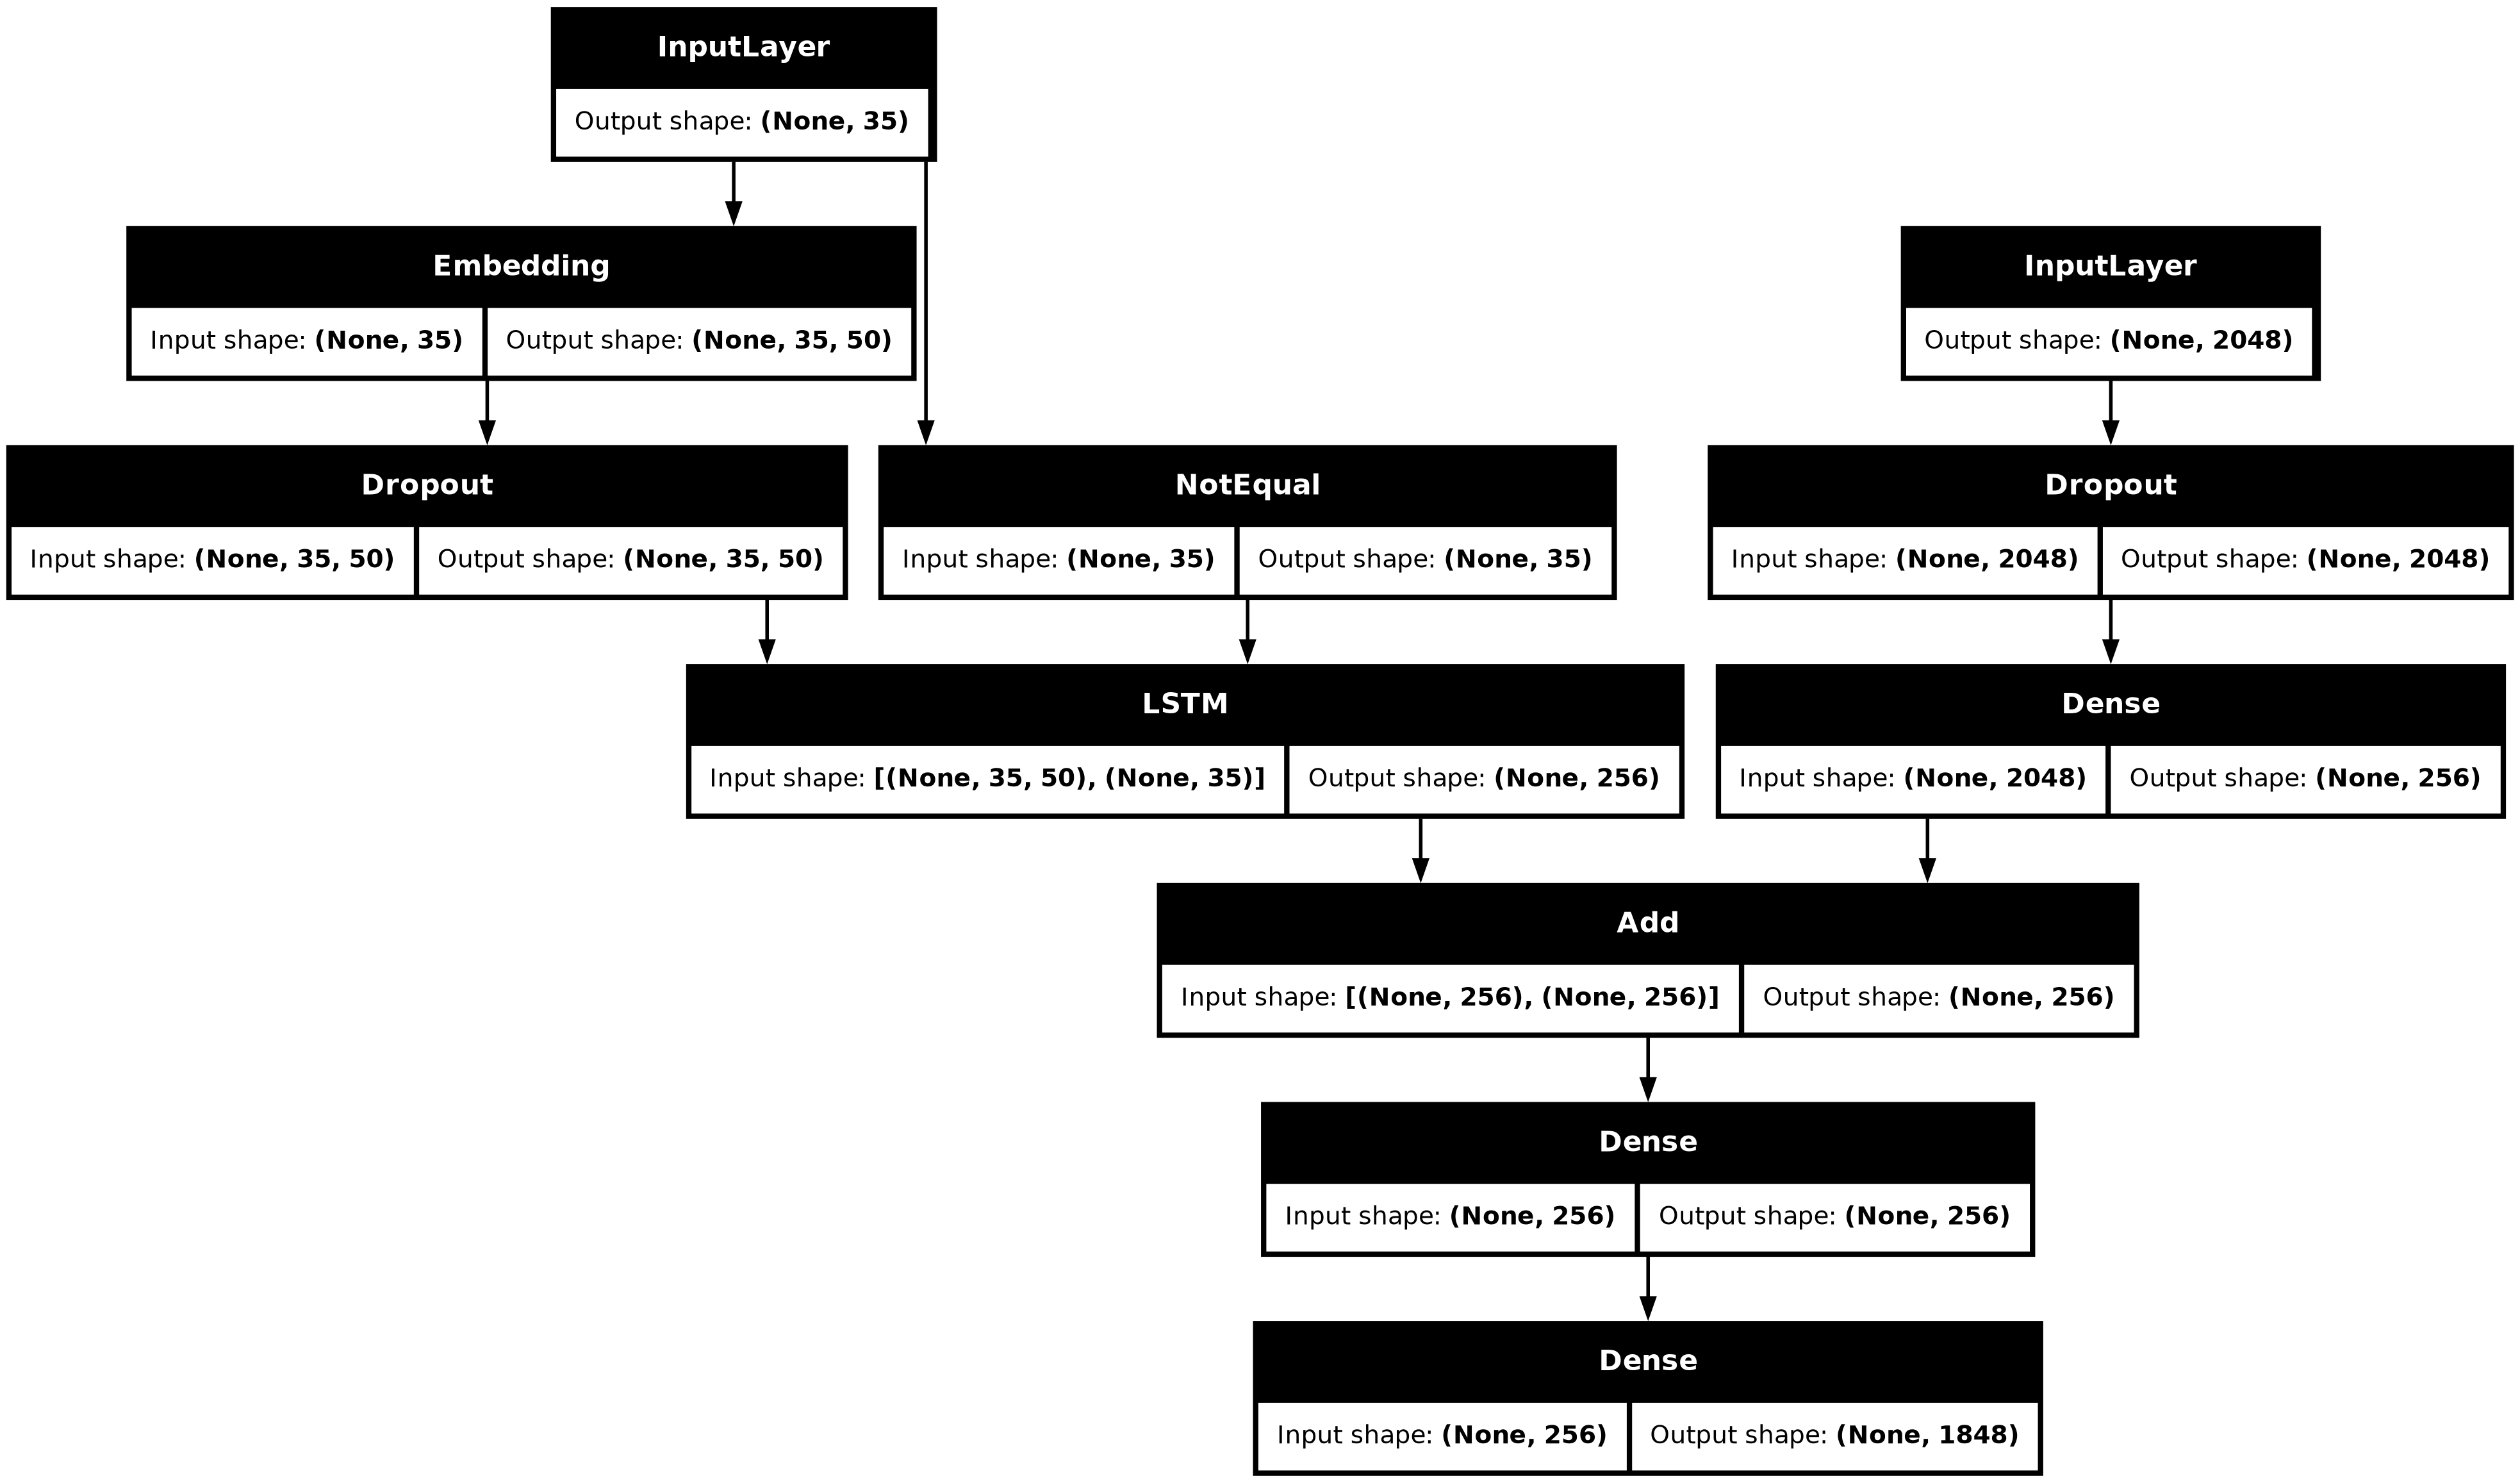

In [69]:
import pydot

import graphviz

tf.keras.utils.plot_model(model, show_shapes=True)

In [66]:
import os

if not os.path.exists('/model_weights/'):

    os.makedirs('/model_weights/')


In [71]:
import tensorflow as tf


def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size, vocab_size):

    X1, X2, y = [], [], []

    n = 0

    while True:

        for key, desc_list in train_descriptions.items():

            n += 1

            photo = encoding_train[key]

            for desc in desc_list:

                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]


                for i in range(1, len(seq)):

                    xi = seq[0:i]

                    yi = seq[i]

                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]

                    yi = to_categorical([yi], num_classes=vocab_size)[0]

                    X1.append(photo)

                    X2.append(xi)

                    y.append(yi)


            if n == batch_size:

                yield ((tf.convert_to_tensor(X1, dtype=tf.float32), tf.convert_to_tensor(X2, dtype=tf.int32)), tf.convert_to_tensor(y, dtype=tf.float32))

                X1, X2, y = [], [], []  # Reset for next batch

                n = 0

        # Yield the remaining data if any after processing all descriptions for the current key

        if len(X1) > 0:

            yield ((tf.convert_to_tensor(X1, dtype=tf.float32), tf.convert_to_tensor(X2, dtype=tf.int32)), tf.convert_to_tensor(y, dtype=tf.float32))

            X1, X2, y = [], [], []

            n = 0


In [72]:
# # model training

# epochs = 20

# batch_size = 32

# steps = len(train_descriptions)//64


# def train():

#     for i in range(epochs):

#         # Create the generator for data

#         generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size, vocab_size   )

#         # Train the model for 1 epoch

#         model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

#         # Save the model after each epoch

#     model.save("/model_" + str(i) + ".keras")

In [74]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

# Parameters
epochs = 50
batch_size = 32
steps = len(train_descriptions) // batch_size

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch > 50:  # Reduce learning rate after 50 epochs
        return lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Early stopping based on training loss
early_stopping = EarlyStopping(
    monitor='loss',         # Monitor training loss
    patience=10,            # Stop after 10 epochs of no improvement
    verbose=1
)



# Train function
def train():
    for i in range(epochs):
        print(f"Epoch {i+1}/{epochs}")
        
        # Create the generator for data
        generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size, vocab_size)
        
        # Train the model for 1 epoch
        model.fit(
            generator,
            epochs=1,
            steps_per_epoch=steps,
            verbose=1,
            callbacks=[ lr_scheduler, early_stopping]
        )
        model.save('/kaggle/working/model_weights/model_'+str(i)+'.keras')

train()


Epoch 1/50

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
187/187 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.1313 - loss: 5.3765 - learning_rate: 0.0010
Epoch 2/50

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
187/187 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.2306 - loss: 4.0961 - learning_rate: 0.0010
Epoch 3/50

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
187/187 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.2599 - loss: 3.7271 - learning_rate: 0.0010
Epoch 4/50

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
187/187 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.2784 - loss: 3.5095 - learning_rate: 0.0010
Epoch 5/50

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
187/187 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.2932 - loss: 3.3553 - learning_rate: 0.0010
Epoch 6/50

Epoch 1: LearningRateScheduler se

In [83]:
import os

# Specify the folder path
folder_path = '/kaggle/working/model_weights2'

# List files in the folder
files = os.listdir(folder_path)
print(files)


[]


In [67]:
from keras.models import load_model
model = load_model('/kaggle/input/trained_model/keras/default/1/model_50.keras')


In [82]:
import os

if not os.path.exists('/kaggle/working/model_weights2/'):

    os.makedirs('/kaggle/working/model_weights2/')


In [84]:
model.save("/kaggle/working/model_weights2/model_50.keras")


In [70]:

def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        final_caption = set()
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() 
        word = idx_to_word[ypred]
        in_text += ' ' + word
        final_caption.add(in_text)
        
        print(in_text)
        
        if word == "endseq":
            break
    final_caption = in_text.split()[1:-1]
    st = ' '.join(final_caption)
    final_caption.clear()
    
    return st


In [71]:
len(encoding_test)

1000

In [72]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
predicted_captions = {}
all_img_names = list(encoding_test.keys())
for i in range(1000):

   
    img_name = all_img_names[i]
    
    photo_2048 = encoding_test[img_name].reshape((1,2048))
   
    caption = predict_caption(photo_2048)
   
    predicted_captions[img_name] = caption
    
    
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
startseq dog jumps to get
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
startseq dog jumps to get yellow
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
startseq dog jumps to get yellow ball
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq dog jumps to get yellow ball endseq


In [ ]:
import pandas as pd

# Convert dictionary to DataFrame
df = pd.DataFrame(list(predicted_captions.items()), columns=["img_id", "caption"])

# Display the DataFrame
df.to_csv("predicted_captions.csv",index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq girl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq girl in
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq girl in striped
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq girl in striped shirt
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq girl in striped shirt is
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq girl in striped shirt is jumping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq girl in striped shirt is jumping in
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq girl in striped shirt is jumping in the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
startseq girl in striped shirt is jumping in the air
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq girl in striped shirt is jumping in the air endseq
girl in striped shirt is jumping in the air


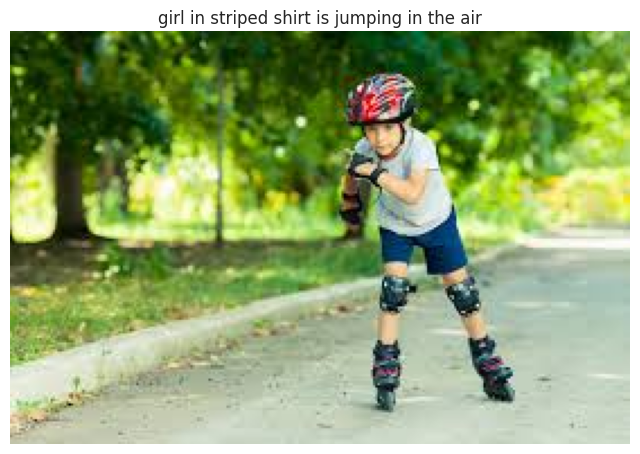

In [103]:
path = "/kaggle/input/testing-mir/images2.jpeg"
pic = encode_image(path).reshape((1,2048))
caption1 = predict_caption(pic)
print(caption1)
i = plt.imread(path)
plt.title(caption1)
plt.imshow(i)
plt.axis("off")
plt.show()

In [98]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in test_descriptions:
    
    captions = test_descriptions[key]
    
    # # predict the caption for image
    y_pred = predicted_captions[key]
    # # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
#calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.468452
BLEU-2: 0.279147
BLEU-3: 0.167669
BLEU-4: 0.095209


3348385580_10b53391f9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
startseq man
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/tmp/ipykernel_30/4176201724.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


startseq man in
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
startseq man in green
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
startseq man in green jacket
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq man in green jacket is
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
startseq man in green jacket is skateboarding
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
startseq man in green jacket is skateboarding on
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
startseq man in green jacket is skateboarding on ramp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
startseq man in green jacket is skateboarding on ramp endseq


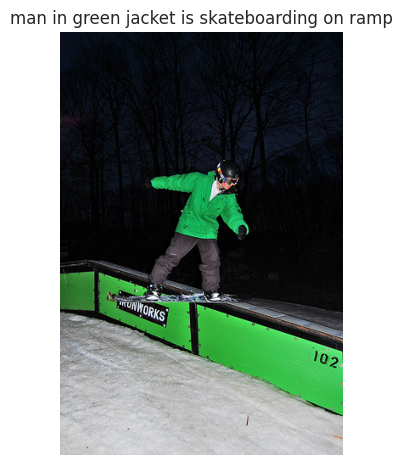

In [101]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(1):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    print(img_name)
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/kaggle/input/mir-flickerdataset/flicker8k dataset/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    